# 문장 토큰 단위 분류 모델 학습

### 1. CPU 및 GPU 환경설정

In [1]:
import torch
import torch
import random
import numpy as np
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
torch.cuda.get_device_name(0)

'CUDA GPU'

### 2. 데이터셋

In [4]:
!git clone https://github.com/kmounlp/NER.git

Cloning into 'NER'...
remote: Enumerating objects: 1770, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 1770 (delta 0), reused 42 (delta 0), pack-reused 1727
Receiving objects: 100% (1770/1770), 20.69 MiB | 12.10 MiB/s, done.
Resolving deltas: 100% (146/146), done.


In [4]:
import os
import glob

In [5]:
file_list = []

In [6]:
for x in os.walk('NER/'):
    for y in glob.glob(os.path.join(x[0], '*_NER.txt')):    # ner.*, *_NER.txt
        file_list.append(y)

In [7]:
file_list = sorted(file_list)

In [8]:
for file_path in file_list:
    print(file_path)

NER/말뭉치 - 형태소_개체명/00002_NER.txt
NER/말뭉치 - 형태소_개체명/00003_NER.txt
NER/말뭉치 - 형태소_개체명/00004_NER.txt
NER/말뭉치 - 형태소_개체명/00005_NER.txt
NER/말뭉치 - 형태소_개체명/00006_NER.txt
NER/말뭉치 - 형태소_개체명/00007_NER.txt
NER/말뭉치 - 형태소_개체명/00008_NER.txt
NER/말뭉치 - 형태소_개체명/00009_NER.txt
NER/말뭉치 - 형태소_개체명/00010_NER.txt
NER/말뭉치 - 형태소_개체명/00011_NER.txt
NER/말뭉치 - 형태소_개체명/00012_NER.txt
NER/말뭉치 - 형태소_개체명/00013_NER.txt
NER/말뭉치 - 형태소_개체명/00014_NER.txt
NER/말뭉치 - 형태소_개체명/00015_NER.txt
NER/말뭉치 - 형태소_개체명/00016_NER.txt
NER/말뭉치 - 형태소_개체명/00017_NER.txt
NER/말뭉치 - 형태소_개체명/00018_NER.txt
NER/말뭉치 - 형태소_개체명/00019_NER.txt
NER/말뭉치 - 형태소_개체명/00020_NER.txt
NER/말뭉치 - 형태소_개체명/00021_NER.txt
NER/말뭉치 - 형태소_개체명/00022_NER.txt
NER/말뭉치 - 형태소_개체명/00023_NER.txt
NER/말뭉치 - 형태소_개체명/00024_NER.txt
NER/말뭉치 - 형태소_개체명/00025_NER.txt
NER/말뭉치 - 형태소_개체명/00026_NER.txt
NER/말뭉치 - 형태소_개체명/00027_NER.txt
NER/말뭉치 - 형태소_개체명/00028_NER.txt
NER/말뭉치 - 형태소_개체명/00029_NER.txt
NER/말뭉치 - 형태소_개체명/00030_NER.txt
NER/말뭉치 - 형태소_개체명/00031_NER.txt
NER/말뭉치 - 형태소_개체명/00032_NER.txt
NER/말뭉치 

### 3. 허깅페이스 트랜스포머 설치

In [9]:
!pip install transformers==4.5.1

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


### 4. 데이터셋 샘플

In [10]:
from pathlib import Path

In [11]:
file_path = file_list[0]
file_path = Path(file_path)
raw_text = file_path.read_text().strip()

In [12]:
print(raw_text[0:1000])

## 1
## 오에 겐자부로는 일본 현대문학의 초석을 놓은 것으로 평가받는 작가 나쓰메 소세키(1867~1916)의 대표작 ‘마음’에 담긴 군국주의적 요소, 야스쿠니 신사 참배 행위까지 소설의 삽화로 동원하며 일본 사회의 ‘비정상성’을 문제 삼는다.
## <오에 겐자부로:PER>는 <일본:LOC> 현대문학의 초석을 놓은 것으로 평가받는 작가 <나쓰메 소세키:PER>(<1867~1916:DUR>)의 대표작 ‘<마음:POH>’에 담긴 군국주의적 요소, <야스쿠니 신사:ORG> 참배 행위까지 소설의 삽화로 동원하며 <일본:ORG> 사회의 ‘비정상성’을 문제 삼는다.
오에	오에	NNG	B-PER
_	_	_	I-PER
겐자부로	겐자부로	NNP	I-PER
는	는	JX	O
_	_	_	O
일본	일본	NNP	B-LOC
_	_	_	O
현대	현대	NNG	O
문학	문학	NNG	O
의	의	JKG	O
_	_	_	O
초석	초석	NNG	O
을	을	JKO	O
_	_	_	O
놓	놓	VV	O
은	은	ETM	O
_	_	_	O
것	것	NNB	O
으로	으로	JKB	O
_	_	_	O
평가	평가	NNG	O
받	받	VV	O
는	는	ETM	O
_	_	_	O
작가	작가	NNG	O
_	_	_	O
나쓰메	나쓰메	NNP	B-PER
_	_	_	I-PER
소세키	소세키	NNP	I-PER
(	(	SS	O
1867	1867	SN	B-DUR
~	~	SO	I-DUR
1916	1916	SN	I-DUR
)	)	SS	O
의	의	JKG	O
_	_	_	O
대표작	대표작	NNG	O
_	_	_	O
‘	‘	SS	O
마음	마음	NNG	B-POH
’	’	SS	O
에	에	JKB	O
_	_	_	O
담긴	담기+ㄴ	VV+ETM	O
_	_	_	O
군국주의	군국주의	NNG	O
적	적	XSN	O
_	_	_	O
요소	요소	NNG	O
,	,	SP	O
_	_	_	O
야스쿠니	야스쿠니	NNP	B-ORG
_	_	_	I-ORG
신사	신사	NNG	I-ORG
_	_	_	O
참배	참배	NNG	O
_	_	_	O
행위	행위	NNG	O
까지	까지	JX	O
_	_	_	O
소설

### 5. 데이터셋 전처리

In [13]:
import pandas as pd

In [16]:
address = pd.read_csv('new_address_list.txt', header=None)
address.columns = ['address']

In [17]:
address.head()

,address
0,서울특별시 강남구 가로수길
1,서울특별시 강남구 강남대로
2,서울특별시 강남구 강남대로100길
3,서울특별시 강남구 강남대로102길
4,서울특별시 강남구 강남대로106길


In [18]:
file_list[0]

'NER/말뭉치 - 형태소_개체명/00002_NER.txt'

In [19]:
import re

In [20]:
random.sample(address['address'].tolist(), k=1)[0]

'제주특별자치도 서귀포시 호근남로'

In [27]:
def read_file(file_list):
    token_docs = []
    tag_docs = []
    for file_path in file_list:
        # print("read file from ", file_path)
        file_path = Path(file_path)
        raw_text = file_path.read_text().strip()
        raw_docs = re.split(r'\n\t?\n', raw_text)
        for doc in raw_docs:
            tokens = []
            tags = []
            for line in doc.split('\n'):
                if line[0:1] == "$" or line[0:1] == ";" or line[0:2] == "##":
                    continue
                try:
                    tag = line.split('\t')[3]   # 2: pos, 3: ner
                    if tag in ['B-LOC', 'I-LOC', 'B-PER', 'I-PER']:
                        if tag == 'B-LOC':
                            token = random.sample(address['address'].tolist(), k=1)[0]
                        elif tag == 'I-LOC':
                            token = None
                        else:
                            token = line.split('\t')[0]                       
                    else:
                        token = line.split('\t')[0]    
                        tag = 'O'
                    for i, syllable in enumerate(token):    # 음절 단위로 잘라서
                        tokens.append(syllable)
                        modi_tag = tag
                        if i > 0:
                            if tag[0] == 'B':
                                modi_tag = 'I' + tag[1:]    # BIO tag를 부착할게요 :-)
                        tags.append(modi_tag)
                except:
                    continue
            token_docs.append(tokens)
            tag_docs.append(tags)

    return token_docs, tag_docs

In [28]:
texts, tags = read_file(file_list[:])

In [29]:
print(len(texts))
print(len(tags))

19263
19263


In [30]:
print(texts[0], end='\n\n') # 음절 단위로 잘 잘렸네요!
print(tags[0])

['오', '에', '_', '겐', '자', '부', '로', '는', '_', '충', '청', '남', '도', ' ', '아', '산', '시', ' ', '운', '교', '길', '9', '1', '번', '길', '_', '현', '대', '문', '학', '의', '_', '초', '석', '을', '_', '놓', '은', '_', '것', '으', '로', '_', '평', '가', '받', '는', '_', '작', '가', '_', '나', '쓰', '메', '_', '소', '세', '키', '(', '1', '8', '6', '7', '~', '1', '9', '1', '6', ')', '의', '_', '대', '표', '작', '_', '‘', '마', '음', '’', '에', '_', '담', '긴', '_', '군', '국', '주', '의', '적', '_', '요', '소', ',', '_', '야', '스', '쿠', '니', '_', '신', '사', '_', '참', '배', '_', '행', '위', '까', '지', '_', '소', '설', '의', '_', '삽', '화', '로', '_', '동', '원', '하', '며', '_', '일', '본', '_', '사', '회', '의', '_', '‘', '비', '정', '상', '성', '’', '을', '_', '문', '제', '_', '삼', '는', '다', '.']

['B-PER', 'I-PER', 'I-PER', 'I-PER', 'I-PER', 'I-PER', 'I-PER', 'O', 'O', 'B-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

In [31]:
unique_tags = set(tag for doc in tags for tag in doc)
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

In [32]:
for i, tag in enumerate(unique_tags):
    print(tag)  # 학습을 위한 label list를 확인합니다.

B-LOC
B-PER
O
I-PER
I-LOC


### 6. EDA

In [33]:
import numpy as np
import matplotlib.pyplot as plt

In [34]:
texts_len = [len(x) for x in texts]

**6.2 문장의 길이의 히스토그램**

Text(0, 0.5, 'Probability')

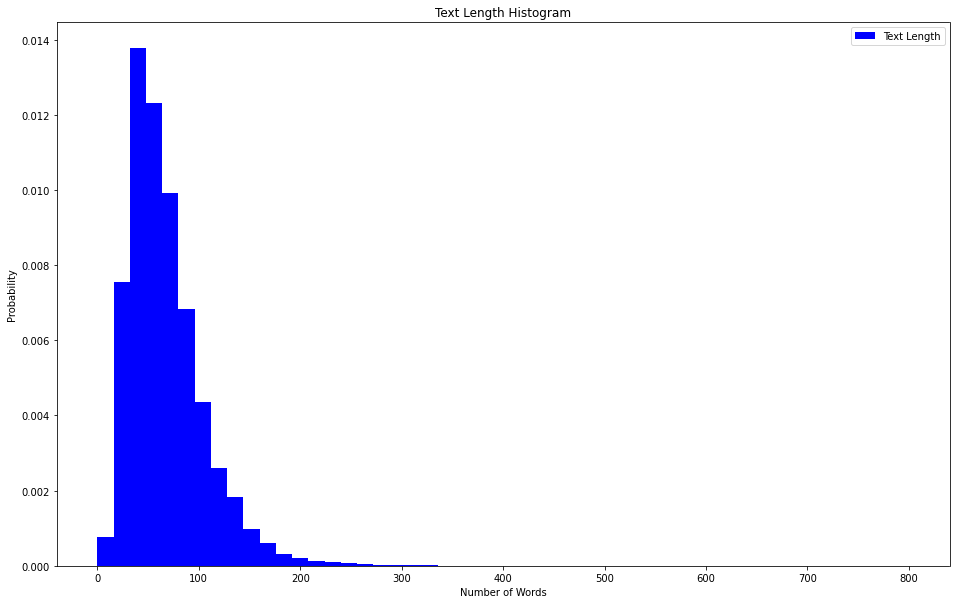

In [35]:
plt.figure(figsize=(16,10))
plt.hist(texts_len, bins=50, range=[0,800], facecolor='b', density=True, label='Text Length')
plt.title('Text Length Histogram')
plt.legend()
plt.xlabel('Number of Words')
plt.ylabel('Probability')

**6.4 각 NER 태그별 데이터에 포함된 갯수**

In [36]:
for tag in list(tag2id.keys()) : 
    globals()[tag] = 0

In [37]:
for tag in tags : 
    for ner in tag : 
        globals()[ner] += 1

In [38]:
for tag in list(tag2id.keys()) : 
    print('{:>6} : {:>7,}'. format(tag, globals()[tag]))

 B-LOC :   6,313
 B-PER :  13,779
     O : 1,159,513
 I-PER :  26,206
 I-LOC :  89,040


### 7. Train Test Split

In [39]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_tags, test_tags = train_test_split(texts, tags, test_size=.2, random_state=42)

In [40]:
print('Train 문장 : {:>6,}' .format(len(train_texts)))
print('Train 태그 : {:>6,}' .format(len(train_tags)))
print('Test  문장 : {:>6,}' .format(len(test_texts)))
print('Test  태그 : {:>6,}' .format(len(test_tags)))

Train 문장 : 15,410
Train 태그 : 15,410
Test  문장 :  3,853
Test  태그 :  3,853


In [41]:
train_texts[5]

['강',
 '민',
 '호',
 '는',
 '_',
 '5',
 '일',
 '_',
 '오',
 '후',
 '_',
 '1',
 '시',
 '_',
 '경',
 '상',
 '남',
 '도',
 ' ',
 '사',
 '천',
 '시',
 ' ',
 '당',
 '산',
 '1',
 '길',
 '_',
 '충',
 '청',
 '남',
 '도',
 ' ',
 '서',
 '천',
 '군',
 ' ',
 '송',
 '마',
 '길',
 '9',
 '7',
 '번',
 '길',
 '_',
 '3',
 '층',
 '_',
 '크',
 '리',
 '스',
 '탈',
 '_',
 '볼',
 '룸',
 '에',
 '서',
 '_',
 '신',
 '부',
 '_',
 '신',
 '소',
 '연',
 '과',
 '_',
 '결',
 '혼',
 '식',
 '을',
 '_',
 '올',
 '렸',
 '다',
 '.']

### 8. BERT 토크나이저

In [42]:
from transformers import AutoModel, AutoTokenizer, BertTokenizer
MODEL_NAME = "monologg/koelectra-base-v3-discriminator"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/467 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

In [43]:
pad_token_id = tokenizer.pad_token_id # 0
cls_token_id = tokenizer.cls_token_id # 101
sep_token_id = tokenizer.sep_token_id # 102
pad_token_label_id = tag2id['O']    # tag2id['O']
cls_token_label_id = tag2id['O']
sep_token_label_id = tag2id['O']

In [44]:
# 기존 토크나이저는 wordPiece tokenizer로 tokenizing 결과를 반환합니다.
# 데이터 단위를 음절 단위로 변경했기 때문에, tokenizer도 음절 tokenizer로 바꿀게요! :-)

# berttokenizer를 쓸건데 여기에 들어있는 8000개 밖에 안되는 한국어가 들어있지만
# 많은 수가 음절이다. 그래서 음절로 쪼개면 UNK가 별로 없을듯.
def ner_tokenizer(sent, max_seq_length):    
    pre_syllable = "_"
    input_ids = [pad_token_id] * (max_seq_length - 1)
    attention_mask = [0] * (max_seq_length - 1)
    token_type_ids = [0] * max_seq_length
    sent = sent[:max_seq_length-2]

    for i, syllable in enumerate(sent):
        if syllable == '_':
            pre_syllable = syllable
        if pre_syllable != "_":
            syllable = '##' + syllable  # 중간 음절에는 모두 prefix를 붙입니다.
            # 우리가 구성한 학습 데이터도 이렇게 구성되었기 때문이라고 함.
            # 이순신은 조선 -> [이, ##순, ##신, ##은, 조, ##선]
        pre_syllable = syllable

        input_ids[i] = (tokenizer.convert_tokens_to_ids(syllable))
        attention_mask[i] = 1
    
    input_ids = [cls_token_id] + input_ids
    input_ids[len(sent)+1] = sep_token_id
    attention_mask = [1] + attention_mask
    attention_mask[len(sent)+1] = 1
    return {"input_ids":input_ids,
            "attention_mask":attention_mask,
            "token_type_ids":token_type_ids}

In [45]:
print(ner_tokenizer(train_texts[0], 5))
# 'token_type_ids': [0, 0, 0, 0, 0] 은 segmentA로 0000으로 되어있는거.

{'input_ids': [2, 3263, 4246, 4189, 3], 'attention_mask': [1, 1, 1, 1, 1], 'token_type_ids': [0, 0, 0, 0, 0]}


In [46]:
tokenized_train_sentences = []
tokenized_test_sentences = []

for text in train_texts:    # 전체 데이터를 tokenizing 합니다.
    tokenized_train_sentences.append(ner_tokenizer(text, 128))
for text in test_texts:
    tokenized_test_sentences.append(ner_tokenizer(text, 128))

In [47]:
# 우리의 label도 truncation과 tokenizing이 필요하다.
def encode_tags(tags, max_seq_length):
    # label 역시 입력 token과 개수를 맞춰줍니다 :-)
    tags = tags[:max_seq_length-2]
    labels = [tag2id[tag] for tag in tags]
    labels = [tag2id['O']] + labels

    padding_length = max_seq_length - len(labels)
    labels = labels + ([pad_token_label_id] * padding_length)

    return labels

In [48]:
train_tags[0]

['B-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

In [49]:
tag2id

{'B-LOC': 0, 'B-PER': 1, 'O': 2, 'I-PER': 3, 'I-LOC': 4}

In [50]:
encode_tags(train_tags[0], 5)

[2, 1, 3, 3, 2]

In [51]:
train_labels = []
test_labels = []

for tag in train_tags:
    train_labels.append(encode_tags(tag, 128))

for tag in test_tags:
    test_labels.append(encode_tags(tag, 128))

In [52]:
len(train_labels), len(test_labels)

(15410, 3853)

### 9. Token 데이터셋

In [53]:
import torch

# 여기 부터는 이제 지겨워지죠? :-)
class TokenDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val) for key, val in self.encodings[idx].items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TokenDataset(tokenized_train_sentences, train_labels)
test_dataset = TokenDataset(tokenized_test_sentences, test_labels)

In [54]:
# BertForSencenceClassification이 아니다! token이 목적이야
from transformers import BertForTokenClassification, Trainer, TrainingArguments, AutoModelForTokenClassification
import sys
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    learning_rate=3e-5,
    save_total_limit=5
)

### 10. BertForTokenClassification

In [55]:
model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, num_labels=len(unique_tags))
model.to(device)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset            # evaluation dataset
)

Downloading:   0%|          | 0.00/452M [00:00<?, ?B/s]

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForTokenClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier

In [56]:
trainer.train()

Step,Training Loss
100,0.287800
200,0.140400
300,0.074100
400,0.044300
500,0.072400
600,0.063800
700,0.089300
800,0.082300
900,0.052300
1000,0.031300


TrainOutput(global_step=9635, training_loss=0.019702833991441692, metrics={'train_runtime': 999.0052, 'train_samples_per_second': 9.645, 'total_flos': 6647332376716800.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 4677632, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 27529216, 'train_mem_gpu_alloc_delta': 1379744768, 'train_mem_cpu_peaked_delta': 215019520, 'train_mem_gpu_peaked_delta': 899900416})

In [57]:
trainer.evaluate()

{'eval_loss': 0.02390233241021633,
 'eval_runtime': 4.3482,
 'eval_samples_per_second': 886.104,
 'epoch': 5.0,
 'eval_mem_cpu_alloc_delta': 135168,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_peaked_delta': 277135360}

In [58]:
predictions = trainer.predict(test_dataset)
print(predictions.predictions.shape, predictions.label_ids.shape)

(3853, 128, 5) (3853, 128)


In [59]:
import numpy as np

preds = np.argmax(predictions.predictions, axis=-1)

In [60]:
index_to_ner = {i:j for j, i in tag2id.items()}
f_label = [i for i, j in tag2id.items()]
val_tags_l = [index_to_ner[x] for x in np.ravel(predictions.label_ids).astype(int).tolist()]
y_predicted_l = [index_to_ner[x] for x in np.ravel(preds).astype(int).tolist()]

In [61]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [77]:
print(classification_report(val_tags_l, y_predicted_l, labels=f_label))

              precision    recall  f1-score   support

       B-LOC       0.97      1.00      0.99      1163
       B-PER       0.91      0.92      0.91      2698
           O       1.00      1.00      1.00    468149
       I-PER       0.93      0.90      0.91      5011
       I-LOC       0.97      1.00      0.98     16163

    accuracy                           1.00    493184
   macro avg       0.96      0.96      0.96    493184
weighted avg       1.00      1.00      1.00    493184



In [79]:
trainer.save_model('koelectra')

In [87]:
model = model.from_pretrained('koelectra').to(device)

### 11. New Data Inference

In [88]:
# 우리가 전에 사용했던건 word piece tokenizer
# 지금 사용한건 음절단위 tokenizer
# 반드시 음절 tokenizer를 거친 후에 model에 들어가야 한다.

def ner_inference(text) : 
  
    model.eval()
    text = text.replace(' ', '_')

    predictions, true_labels = [], []
    
    tokenized_sent = ner_tokenizer(text, len(text)+2)
    input_ids = torch.tensor(tokenized_sent['input_ids']).unsqueeze(0).to(device)
    attention_mask = torch.tensor(tokenized_sent['attention_mask']).unsqueeze(0).to(device)
    token_type_ids = torch.tensor(tokenized_sent['token_type_ids']).unsqueeze(0).to(device)    
    
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
    logits = outputs['logits']
    logits = logits.detach().cpu().numpy()
    label_ids = token_type_ids.cpu().numpy()

    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.append(label_ids)

    pred_tags = [list(tag2id.keys())[p_i] for p in predictions for p_i in p]

    print('{}\t{}'.format("TOKEN", "TAG"))
    print("===========")
    # for token, tag in zip(tokenizer.decode(tokenized_sent['input_ids']), pred_tags):
    #   print("{:^5}\t{:^5}".format(token, tag))
    for i, tag in enumerate(pred_tags):
        print("{:^5}\t{:^5}".format(tokenizer.convert_ids_to_tokens(tokenized_sent['input_ids'][i]), tag))

In [89]:
text = '이순신은 조선 중기의 무신이다.'

In [90]:
ner_inference(text)

TOKEN	TAG
[CLS]	  O  
  이  	B-PER
 ##순 	I-PER
 ##신 	I-PER
 ##은 	  O  
  _  	  O  
  조  	  O  
 ##선 	  O  
  _  	  O  
  중  	  O  
 ##기 	  O  
 ##의 	  O  
  _  	  O  
  무  	  O  
 ##신 	  O  
 ##이 	  O  
 ##다 	  O  
[UNK]	  O  
[SEP]	  O  


In [91]:
text = '안녕하세요 저는 이지평이라고 합니다. 국민대학교에 다니고 있으며, 현재는 4학년 1학기를 마쳤습니다.'
ner_inference(text)

TOKEN	TAG
[CLS]	  O  
  안  	  O  
 ##녕 	  O  
 ##하 	  O  
 ##세 	  O  
 ##요 	  O  
  _  	  O  
  저  	  O  
 ##는 	  O  
  _  	  O  
  이  	B-PER
 ##지 	I-PER
 ##평 	I-PER
 ##이 	  O  
 ##라 	  O  
 ##고 	  O  
  _  	  O  
  합  	  O  
 ##니 	  O  
 ##다 	  O  
[UNK]	  O  
  _  	  O  
  국  	  O  
 ##민 	  O  
 ##대 	  O  
 ##학 	  O  
 ##교 	  O  
 ##에 	  O  
  _  	  O  
  다  	  O  
 ##니 	  O  
 ##고 	  O  
  _  	  O  
  있  	  O  
 ##으 	  O  
 ##며 	  O  
[UNK]	  O  
  _  	  O  
  현  	  O  
 ##재 	  O  
 ##는 	  O  
  _  	  O  
  4  	  O  
 ##학 	  O  
 ##년 	  O  
  _  	  O  
  1  	  O  
 ##학 	  O  
 ##기 	  O  
 ##를 	  O  
  _  	  O  
  마  	  O  
 ##쳤 	  O  
 ##습 	  O  
 ##니 	  O  
 ##다 	  O  
[UNK]	  O  
[SEP]	  O  


In [92]:
text = '이지평'
ner_inference(text)

TOKEN	TAG
[CLS]	  O  
  이  	B-PER
 ##지 	I-PER
 ##평 	I-PER
[SEP]	  O  


In [93]:
text = '마민정'
ner_inference(text)

TOKEN	TAG
[CLS]	  O  
  마  	B-PER
 ##민 	I-PER
 ##정 	I-PER
[SEP]	  O  


In [94]:
text = '유광열'
ner_inference(text)

TOKEN	TAG
[CLS]	  O  
  유  	B-PER
 ##광 	I-PER
 ##열 	I-PER
[SEP]	  O  


In [95]:
text = '유노윤호'
ner_inference(text)

TOKEN	TAG
[CLS]	  O  
  유  	B-PER
 ##노 	I-PER
 ##윤 	I-PER
 ##호 	I-PER
[SEP]	  O  


In [96]:
text = '크리스토퍼'
ner_inference(text)

TOKEN	TAG
[CLS]	  O  
  크  	  O  
 ##리 	  O  
 ##스 	  O  
 ##토 	  O  
 ##퍼 	  O  
[SEP]	  O  


In [97]:
text = '경기도 의정부시 의정로202번길'
ner_inference(text)

TOKEN	TAG
[CLS]	  O  
  경  	B-LOC
 ##기 	I-LOC
 ##도 	I-LOC
  _  	I-LOC
  의  	I-LOC
 ##정 	I-LOC
 ##부 	I-LOC
 ##시 	I-LOC
  _  	I-LOC
  의  	I-LOC
 ##정 	I-LOC
 ##로 	I-LOC
 ##2 	I-LOC
 ##0 	I-LOC
 ##2 	I-LOC
 ##번 	I-LOC
 ##길 	I-LOC
[SEP]	  O  


In [98]:
text = '경기도 의정부시 의정로'
ner_inference(text)

TOKEN	TAG
[CLS]	  O  
  경  	B-LOC
 ##기 	I-LOC
 ##도 	I-LOC
  _  	I-LOC
  의  	I-LOC
 ##정 	I-LOC
 ##부 	I-LOC
 ##시 	I-LOC
  _  	I-LOC
  의  	I-LOC
 ##정 	I-LOC
 ##로 	I-LOC
[SEP]	  O  


In [99]:
text = '이지평 경기도 의정부시 의정로202번길'
ner_inference(text)

TOKEN	TAG
[CLS]	  O  
  이  	B-PER
 ##지 	I-PER
 ##평 	I-PER
  _  	  O  
  경  	B-LOC
 ##기 	I-LOC
 ##도 	I-LOC
  _  	I-LOC
  의  	I-LOC
 ##정 	I-LOC
 ##부 	I-LOC
 ##시 	I-LOC
  _  	I-LOC
  의  	I-LOC
 ##정 	I-LOC
 ##로 	I-LOC
 ##2 	I-LOC
 ##0 	I-LOC
 ##2 	I-LOC
 ##번 	I-LOC
 ##길 	I-LOC
[SEP]	  O  


In [100]:
text = '안녕하세요 저는 이지평입니다. 지금은 경기도 의정부시 의정로에 살고 있습니다.'
ner_inference(text)

TOKEN	TAG
[CLS]	  O  
  안  	  O  
 ##녕 	  O  
 ##하 	  O  
 ##세 	  O  
 ##요 	  O  
  _  	  O  
  저  	  O  
 ##는 	  O  
  _  	  O  
  이  	B-PER
 ##지 	I-PER
 ##평 	I-PER
 ##입 	  O  
 ##니 	  O  
 ##다 	  O  
[UNK]	  O  
  _  	  O  
  지  	  O  
 ##금 	  O  
 ##은 	  O  
  _  	  O  
  경  	B-LOC
 ##기 	I-LOC
 ##도 	I-LOC
  _  	I-LOC
  의  	I-LOC
 ##정 	I-LOC
 ##부 	I-LOC
 ##시 	I-LOC
  _  	I-LOC
  의  	I-LOC
 ##정 	I-LOC
 ##로 	I-LOC
 ##에 	  O  
  _  	  O  
  살  	  O  
 ##고 	  O  
  _  	  O  
  있  	  O  
 ##습 	  O  
 ##니 	  O  
 ##다 	  O  
[UNK]	  O  
[SEP]	  O  
